In [65]:
from d2l import torch as d2l
from torch.utils import data

In [57]:
def use_svg_display():  #@save
    """使用svg格式在Jupyter中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')

In [58]:
def set_figsize(figsize=(3.5, 2.5)):  #@save
    """设置matplotlib的图表大小"""
    use_svg_display()
    d2l.plt.rcParams['figure.figsize'] = figsize

In [59]:
def set_figsize(figsize=(3.5, 2.5)):  #@save
    """设置matplotlib的图表大小"""
    use_svg_display()
    d2l.plt.rcParams['figure.figsize'] = figsize

In [60]:
#@save
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else d2l.plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

In [64]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests
import torch
#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [3]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [4]:
# 如果你没有安装pandas，请取消下一行的注释
import numpy as np
import pandas as pd
from torch import nn

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载../data/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载../data/kaggle_house_pred_test.csv...


In [10]:
print(train_data.shape)
print(test_data.shape)


(1460, 81)
(1459, 80)


In [11]:
train_data.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


In [12]:
test_data.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal


In [13]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [14]:
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [72]:
all_features.shape

(2919, 331)

In [30]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [31]:
all_features = pd.get_dummies(all_features, dummy_na=True)

In [32]:
all_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,0,1,0,0,0,0,0,1,0,0


In [ ]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [34]:
train_data.shape

(1460, 81)

In [35]:
all_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,0,1,0,0,0,0,0,1,0,0


In [39]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [70]:
train_features

tensor([[ 0.0673, -0.1844, -0.2178,  ...,  1.0000,  0.0000,  0.0000],
        [-0.8735,  0.4581, -0.0720,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0673, -0.0559,  0.1372,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [ 0.3025, -0.1416, -0.1428,  ...,  1.0000,  0.0000,  0.0000],
        [-0.8735, -0.0559, -0.0572,  ...,  1.0000,  0.0000,  0.0000],
        [-0.8735,  0.2439, -0.0293,  ...,  1.0000,  0.0000,  0.0000]])

In [71]:
train_labels

tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]])

In [40]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [44]:
all_features[:n_train].values.shape

(1460, 331)

In [48]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [66]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    print('train_iter==>',train_iter)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [67]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [68]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

train_iter==> <torch.utils.data.dataloader.DataLoader object at 0x7f9011bbf310>
折1，训练log rmse0.170398, 验证log rmse0.156842
train_iter==> <torch.utils.data.dataloader.DataLoader object at 0x7f9027bd0430>
折2，训练log rmse0.162574, 验证log rmse0.188403
train_iter==> <torch.utils.data.dataloader.DataLoader object at 0x7f90270c4a30>
折3，训练log rmse0.163874, 验证log rmse0.168345
train_iter==> <torch.utils.data.dataloader.DataLoader object at 0x7f90270c0e50>
折4，训练log rmse0.168094, 验证log rmse0.154623
train_iter==> <torch.utils.data.dataloader.DataLoader object at 0x7f90270c4a30>
折5，训练log rmse0.162885, 验证log rmse0.182544
5-折验证: 平均训练log rmse: 0.165565, 平均验证log rmse: 0.170151


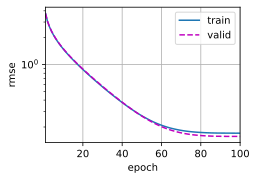

In [69]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [73]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).asnumpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('../data/submission.csv', index=False)

In [ ]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

In [74]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [75]:
device = torch.device('mps')

In [79]:
device

device(type='mps')

In [82]:
x = torch.Tensor([1],device='mps:0')

RuntimeError: legacy constructor expects device type: cpu but device type: mps was passed

In [78]:
x.cuda(device=device)

RuntimeError: Invalid device, must be cuda device

In [84]:
y = torch.tensor([1],device="mps:0")

In [85]:
y

tensor([1], device='mps:0')

In [86]:
a = torch.rand(2,2)

In [89]:
a.device(device='mps:0')

TypeError: 'torch.device' object is not callable